In [1]:
# Install required packages
!pip install seaborn pmdarima pyswarm --quiet

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
from pyswarm import pso
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the sea temperature dataset
data = pd.read_excel('sea_temp.xlsx', sheet_name='SST')

# Convert Date column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')

# Rename the target column for easier handling
data = data.rename(columns={'Sea Surface Temperature (Deg C)': 'Temperature'})

# Keep only the temperature column for analysis
temp_data = data[['Temperature']].copy()

print("Dataset Info:")
print(f"Shape: {temp_data.shape}")
print(f"Date range: {temp_data.index.min()} to {temp_data.index.max()}")
print("\nFirst few rows:")
print(temp_data.head())

print("\nBasic Statistics:")
print(temp_data.describe())

Dataset Info:
Shape: (1480, 1)
Date range: 1900-01-01 00:00:00 to 2023-04-01 00:00:00

First few rows:
            Temperature
Date                   
1900-01-01        26.32
1900-02-01        26.45
1900-03-01        27.57
1900-04-01        29.15
1900-05-01        29.76

Basic Statistics:
       Temperature
count  1480.000000
mean     28.168426
std       1.066242
min      25.670000
25%      27.370000
50%      28.340000
75%      28.940000
max      30.660000


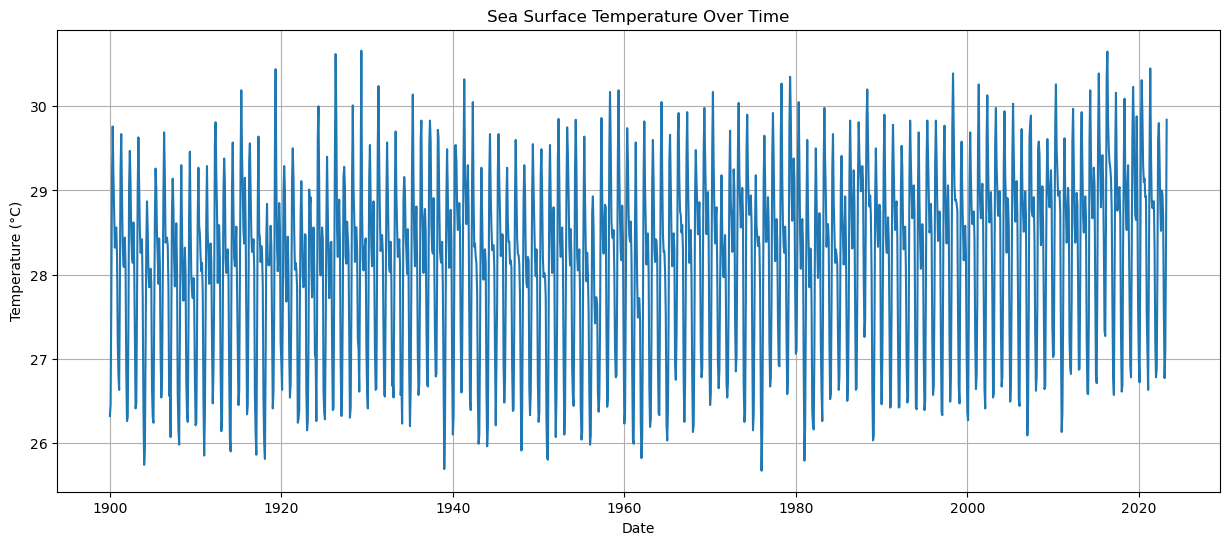

In [3]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(temp_data.index, temp_data['Temperature'])
plt.title('Sea Surface Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

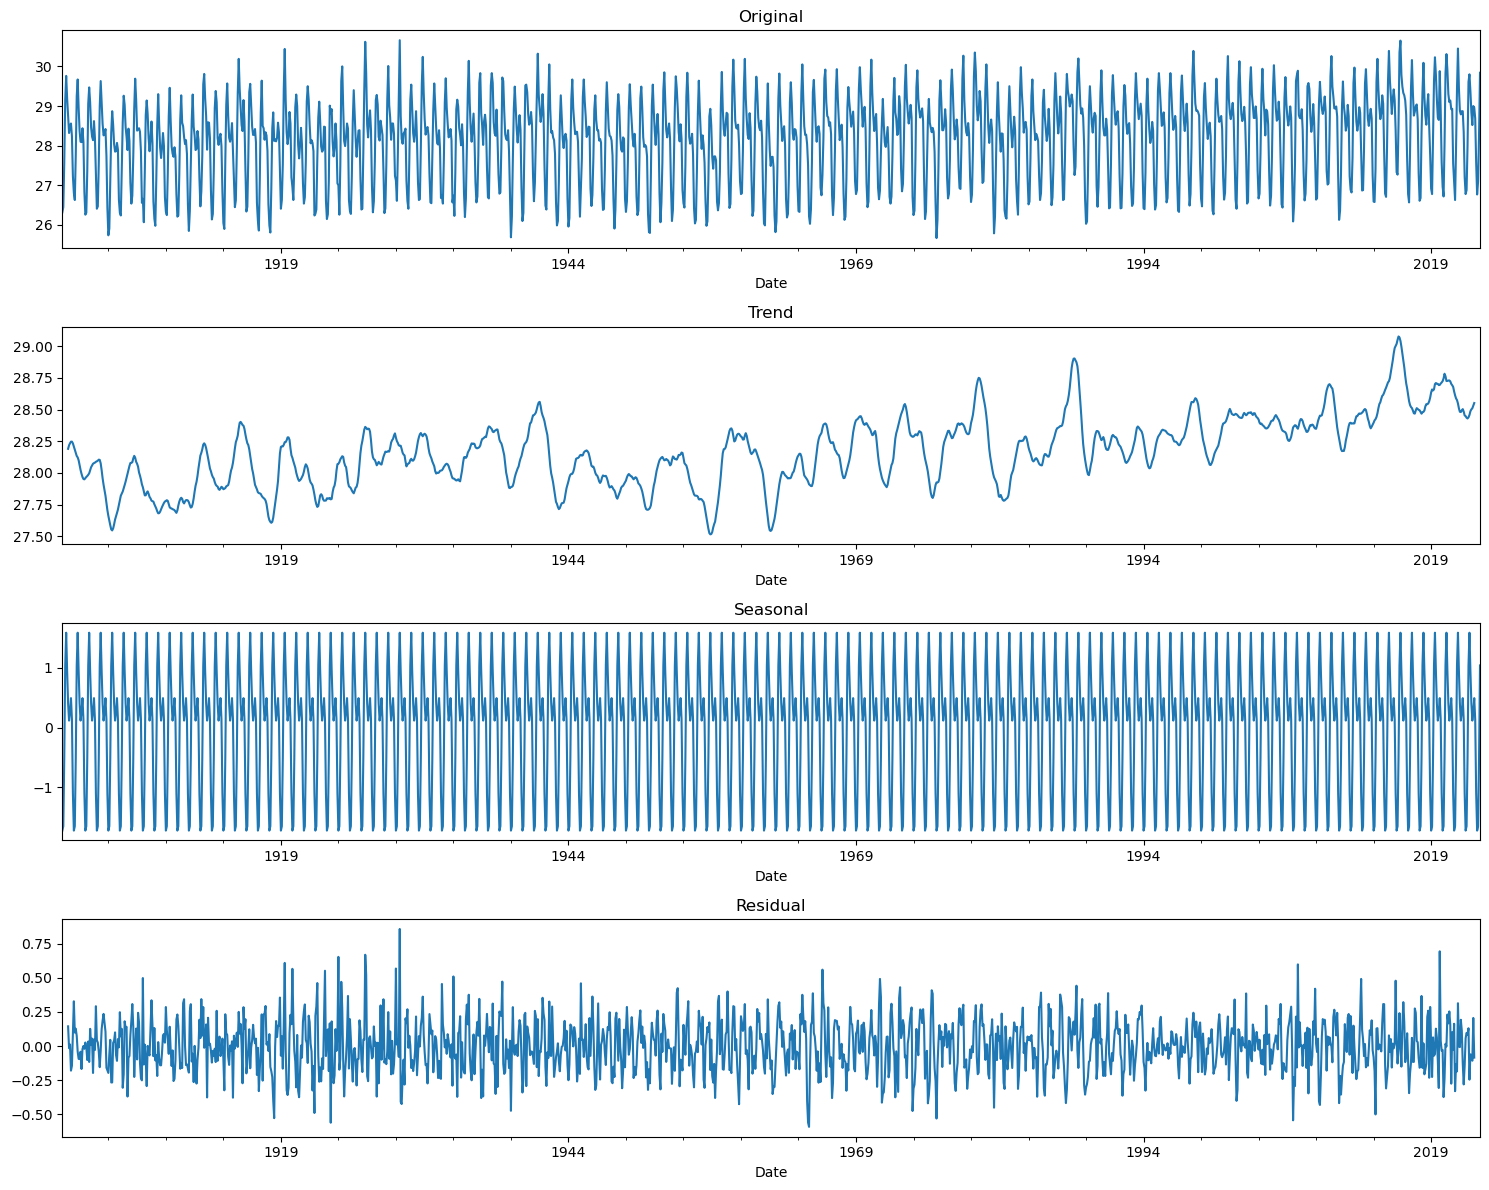

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(temp_data['Temperature'], 
                                 model='additive', 
                                 period=12)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [5]:
# =============================================================================
# STATIONARITY CHECK FUNCTION
# =============================================================================

def check_stationarity(ts, window_size=12, alpha=0.05):
    """
    Check stationarity using ADF test and rolling statistics
    """
    # Calculate rolling statistics
    rolling_mean = ts.rolling(window=window_size).mean()
    rolling_std = ts.rolling(window=window_size).std()
    
    # Perform ADF test
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                        index=['Test Statistic', 'p-value', 
                              '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    
    print(dfoutput)
    
    if dftest[1] < alpha:
        print('✓ Reject null hypothesis. The data is stationary.')
        is_stationary = True
    else:
        print('✗ Fail to reject null hypothesis. The data is non-stationary.')
        is_stationary = False
    
    print('-' * 60)
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Original', alpha=0.7)
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='black')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()
    
    return is_stationary

=== STATIONARITY CHECK FOR ORIGINAL DATA ===
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -3.992216
p-value                           0.001452
#Lags Used                       24.000000
Number of Observations Used    1455.000000
Critical Value (1%)              -3.434852
Critical Value (5%)              -2.863528
Critical Value (10%)             -2.567829
dtype: float64
✓ Reject null hypothesis. The data is stationary.
------------------------------------------------------------


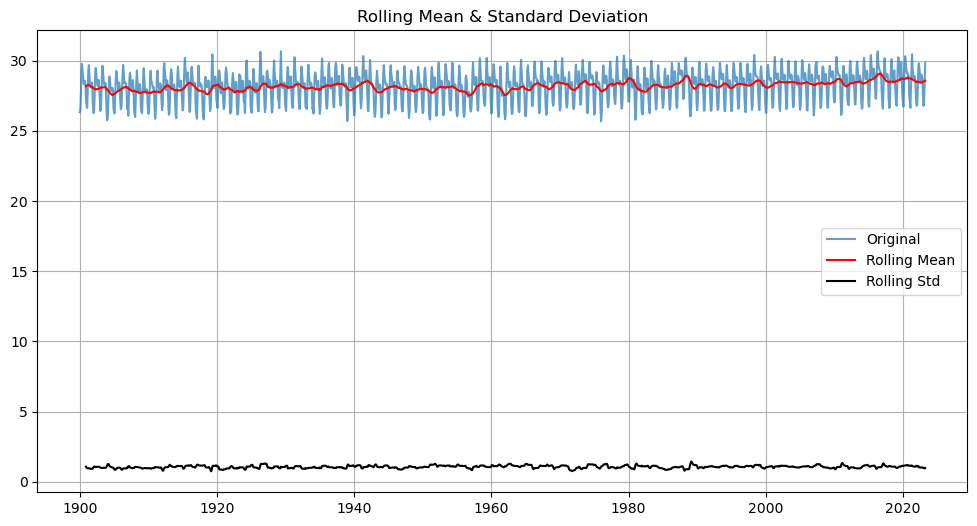

In [6]:

# =============================================================================
# STATIONARITY ANALYSIS
# =============================================================================

print("=== STATIONARITY CHECK FOR ORIGINAL DATA ===")
is_stationary_original = check_stationarity(temp_data['Temperature'])

# If not stationary, apply differencing
if not is_stationary_original:
    print("\n=== APPLYING FIRST DIFFERENCING ===")
    temp_diff = temp_data['Temperature'].diff().dropna()
    is_stationary_diff = check_stationarity(temp_diff)
    
    if not is_stationary_diff:
        print("\n=== APPLYING SEASONAL DIFFERENCING ===")
        temp_seasonal_diff = temp_data['Temperature'].diff(12).dropna()
        is_stationary_seasonal = check_stationarity(temp_seasonal_diff)
        
        if not is_stationary_seasonal:
            print("\n=== APPLYING BOTH DIFFERENCING ===")
            temp_both_diff = temp_data['Temperature'].diff().diff(12).dropna()
            check_stationarity(temp_both_diff)

=== ACF/PACF FOR DIFFERENCED DATA ===


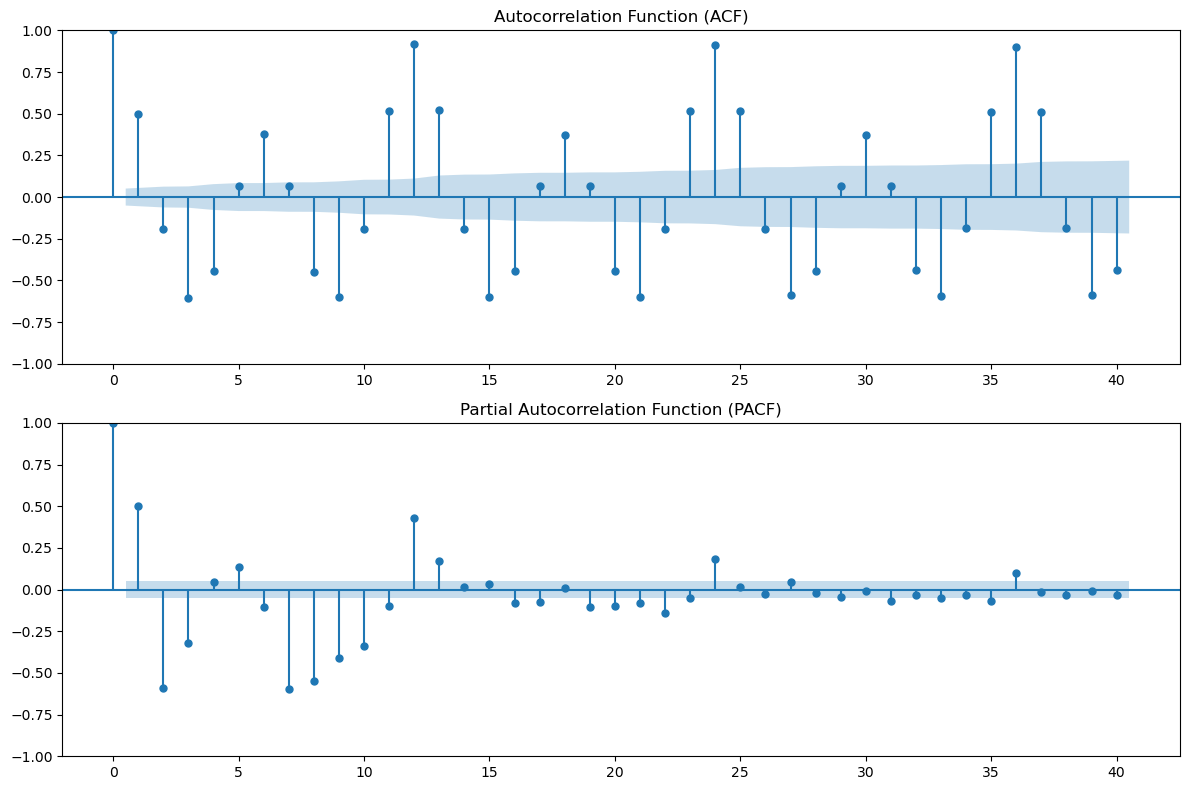

In [7]:
# =============================================================================
# ACF AND PACF PLOTS
# =============================================================================

def plot_acf_pacf(ts, lags=40):
    """Plot ACF and PACF"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')
    
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

print("=== ACF/PACF FOR DIFFERENCED DATA ===")
temp_diff = temp_data['Temperature'].diff().dropna()
plot_acf_pacf(temp_diff)

In [8]:
# =============================================================================
# MODEL TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def split_data(data, test_size=24):
    """Split data into train and test sets"""
    train_size = len(data) - test_size
    train = data.iloc[:train_size]
    test = data.iloc[train_size:]
    return train, test

def evaluate_model(actual, predicted, model_name):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MSE': mse}

# Split the data
train_data, test_data = split_data(temp_data['Temperature'], test_size=24)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (1456,)
Test data shape: (24,)


In [9]:
# =============================================================================
# ARIMA MODEL
# =============================================================================

print("\n" + "="*50)
print("ARIMA MODEL IMPLEMENTATION")
print("="*50)

# Auto ARIMA to find best parameters
print("Finding optimal ARIMA parameters...")
auto_arima_model = pm.auto_arima(train_data,
                                start_p=0, start_q=0,
                                test='adf',
                                max_p=5, max_q=5,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

print(f"Best ARIMA model: {auto_arima_model.order}")

# Fit ARIMA model
arima_order = auto_arima_model.order
arima_model = ARIMA(train_data, order=arima_order)
arima_fitted = arima_model.fit()

print(arima_fitted.summary())

# ARIMA Forecasting
arima_forecast = arima_fitted.forecast(steps=len(test_data))
arima_metrics = evaluate_model(test_data, arima_forecast, "ARIMA")


ARIMA MODEL IMPLEMENTATION
Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13856.249, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11887.892, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2862.312, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2804.579, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2069.022, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2265.919, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1859.006, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1740.625, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.38 s

In [10]:
# =============================================================================
# SARIMA MODEL
# =============================================================================

print("\n" + "="*50)
print("SARIMA MODEL IMPLEMENTATION")
print("="*50)

# Auto SARIMA to find best parameters
print("Finding optimal SARIMA parameters...")
auto_sarima_model = pm.auto_arima(train_data,
                                 start_p=0, start_q=0,
                                 test='adf',
                                 max_p=3, max_q=3,
                                 m=12,
                                 start_P=0, start_Q=0,
                                 max_P=2, max_Q=2,
                                 seasonal=True,
                                 d=None, D=None,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

print(f"Best SARIMA model: {auto_sarima_model.order} x {auto_sarima_model.seasonal_order}")

# Fit SARIMA model
sarima_order = auto_sarima_model.order
sarima_seasonal_order = auto_sarima_model.seasonal_order

sarima_model = SARIMAX(train_data, 
                      order=sarima_order,
                      seasonal_order=sarima_seasonal_order)
sarima_fitted = sarima_model.fit()

print(sarima_fitted.summary())

# SARIMA Forecasting
sarima_forecast = sarima_fitted.forecast(steps=len(test_data))
sarima_metrics = evaluate_model(test_data, sarima_forecast, "SARIMA")


SARIMA MODEL IMPLEMENTATION
Finding optimal SARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4321.138, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2138.699, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13856.249, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3057.508, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=876.317, Time=2.29 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=796.838, Time=1.56 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1722.522, Time=4.58 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=5.63 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=456.088, Time=2.81 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2543.574, Time=0.44 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=329.734, Time=6.05 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   :

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29530D+00    |proj g|=  6.70733D+00

At iterate    5    f=  2.91712D-01    |proj g|=  4.18715D-01

At iterate   10    f=  3.55399D-03    |proj g|=  7.82233D-02

At iterate   15    f= -5.44581D-02    |proj g|=  2.14386D-01

At iterate   20    f= -1.01419D-01    |proj g|=  1.81809D-01

At iterate   25    f= -1.02666D-01    |proj g|=  4.24029D-02

At iterate   30    f= -1.03922D-01    |proj g|=  5.83764D-02

At iterate   35    f= -1.05231D-01    |proj g|=  6.36479D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -1.07775D-01    |proj g|=  3.06092D-02

At iterate   45    f= -1.08754D-01    |proj g|=  2.28580D-02

At iterate   50    f= -1.08771D-01    |proj g|=  3.49061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     95      2     0     0   3.491D-03  -1.088D-01
  F = -0.10877141172261159     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                          Temperature   No. Observations:                 1456
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)

In [ ]:
# =============================================================================
# SARIMAX MODEL (with exogenous variables)
# =============================================================================

print("\n" + "="*50)
print("SARIMAX MODEL IMPLEMENTATION")
print("="*50)

# Create exogenous variables
def create_exogenous_features(data):
    """Create exogenous variables for SARIMAX"""
    df = pd.DataFrame(index=data.index)
    df['month'] = data.index.month
    # df['month_sin'] = np.sin(2 * np.pi * data.index.month / 12)
    # df['month_cos'] = np.cos(2 * np.pi * data.index.month / 12)
    df['trend'] = np.arange(len(data))
    return df

# Create exogenous features for train and test
exog_train = create_exogenous_features(train_data)
exog_test = create_exogenous_features(test_data)

# Fit SARIMAX model
sarimax_model = SARIMAX(train_data,
                       exog=exog_train,
                       order=sarima_order,
                       seasonal_order=sarima_seasonal_order)
sarimax_fitted = sarimax_model.fit()

print(sarimax_fitted.summary())

# SARIMAX Forecasting
sarimax_forecast = sarimax_fitted.forecast(steps=len(test_data), exog=exog_test)
sarimax_metrics = evaluate_model(test_data, sarimax_forecast, "SARIMAX")


SARIMAX MODEL IMPLEMENTATION


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74412D+00    |proj g|=  1.63198D-01

At iterate    5    f=  2.18343D+00    |proj g|=  1.25682D+01

At iterate   10    f=  3.01936D-01    |proj g|=  5.92997D+00

At iterate   15    f=  2.44355D-01    |proj g|=  7.15600D+00

At iterate   20    f=  1.73121D-01    |proj g|=  1.75509D+00

At iterate   25    f=  1.35594D-01    |proj g|=  1.09226D-01

At iterate   30    f=  1.33203D-01    |proj g|=  8.85395D-01

At iterate   35    f=  1.09226D-01    |proj g|=  5.88566D-01

At iterate   40    f=  1.03409D-01    |proj g|=  2.76593D-01

At iterate   45    f=  7.45740D-02    |proj g|=  2.51674D-01

At iterate   50    f=  5.28052D-02    |proj g|=  9.03895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


MODEL COMPARISON
     Model       RMSE        MAE          MSE
0    ARIMA   0.807722   0.723596     0.652415
1   SARIMA   0.228069   0.182875     0.052015
2  SARIMAX  44.669553  44.669115  1995.368928

Best performing model: SARIMA


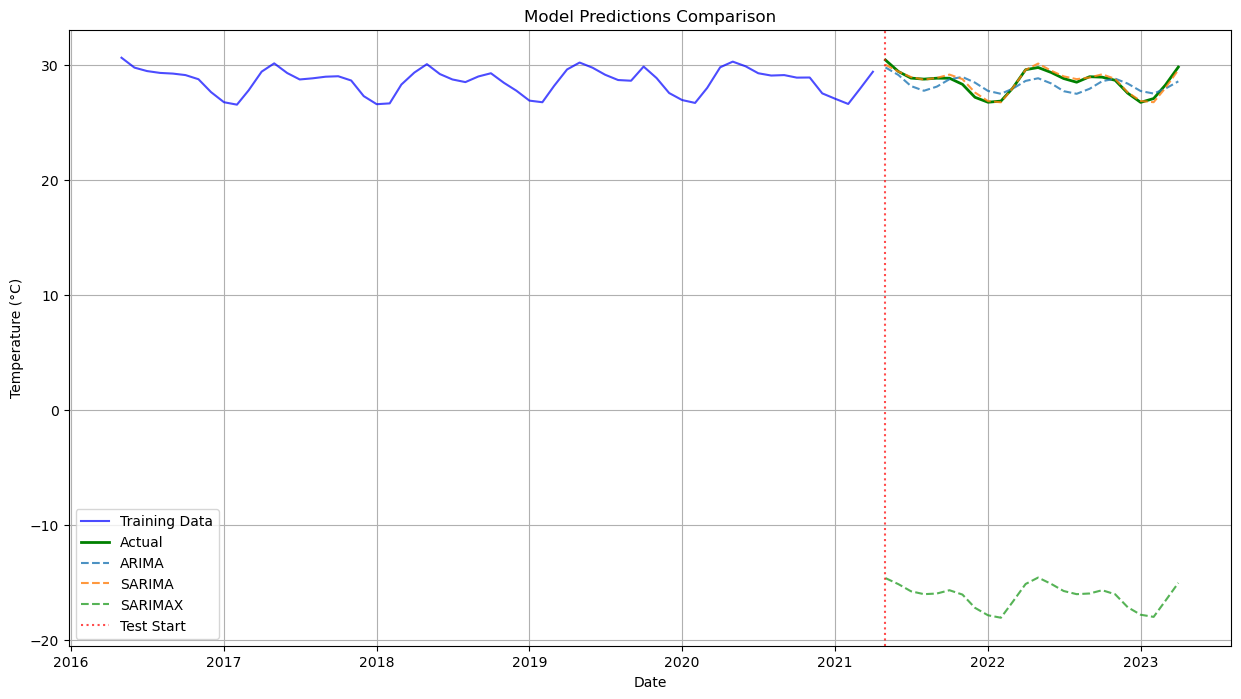

In [12]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'SARIMAX'],
    'RMSE': [arima_metrics['RMSE'], sarima_metrics['RMSE'], sarimax_metrics['RMSE']],
    'MAE': [arima_metrics['MAE'], sarima_metrics['MAE'], sarimax_metrics['MAE']],
    'MSE': [arima_metrics['MSE'], sarima_metrics['MSE'], sarimax_metrics['MSE']]
})

print(results_df)

# Find best performing model
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")

# Plot predictions
plt.figure(figsize=(15, 8))
plt.plot(train_data.index[-60:], train_data.iloc[-60:], 
         label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, label='Actual', color='green', linewidth=2)
plt.plot(test_data.index, arima_forecast, label='ARIMA', linestyle='--', alpha=0.8)
plt.plot(test_data.index, sarima_forecast, label='SARIMA', linestyle='--', alpha=0.8)
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX', linestyle='--', alpha=0.8)
plt.axvline(x=test_data.index[0], color='red', linestyle=':', alpha=0.7, label='Test Start')
plt.title('Model Predictions Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# =============================================================================
# PSO OPTIMIZATION FOR BEST MODEL
# =============================================================================

print("\n" + "="*50)
print("PSO OPTIMIZATION")
print("="*50)

def objective_function_sarima(params):
    """Objective function for PSO optimization of SARIMA parameters"""
    try:
        p, d, q, P, D, Q = [int(max(0, min(param, 3))) for param in params]
        
        # Fit SARIMA model with given parameters
        model = SARIMAX(train_data,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        fitted_model = model.fit(disp=False)
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(test_data))
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        
        return rmse
        
    except:
        return 1e6  # Return large value for invalid parameters

def objective_function_sarimax(params):
    """Objective function for PSO optimization of SARIMAX parameters"""
    try:
        p, d, q, P, D, Q = [int(max(0, min(param, 3))) for param in params]
        
        # Fit SARIMAX model with given parameters
        model = SARIMAX(train_data,
                       exog=exog_train,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        fitted_model = model.fit(disp=False)
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(test_data), exog=exog_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        
        return rmse
        
    except:
        return 1e6  # Return large value for invalid parameters

# PSO parameters
lb = [0, 0, 0, 0, 0, 0]  # Lower bounds for p, d, q, P, D, Q
ub = [3, 2, 3, 2, 1, 2]  # Upper bounds for p, d, q, P, D, Q

# Optimize based on best performing model
if best_model_name == 'SARIMA':
    print("Optimizing SARIMA model with PSO...")
    optimal_params, optimal_rmse = pso(objective_function_sarima, lb, ub, 
                                      swarmsize=20, maxiter=50)
    optimal_params = [int(p) for p in optimal_params]
    
    print(f"Optimal SARIMA parameters: {optimal_params}")
    print(f"Optimal RMSE: {optimal_rmse:.4f}")
    
    # Train optimized model
    optimized_model = SARIMAX(train_data,
                             order=tuple(optimal_params[:3]),
                             seasonal_order=(optimal_params[3], optimal_params[4], optimal_params[5], 12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
    optimized_fitted = optimized_model.fit(disp=False)
    optimized_forecast = optimized_fitted.forecast(steps=len(test_data))
    original_rmse = sarima_metrics['RMSE']

elif best_model_name == 'SARIMAX':
    print("Optimizing SARIMAX model with PSO...")
    optimal_params, optimal_rmse = pso(objective_function_sarimax, lb, ub, 
                                      swarmsize=20, maxiter=50)
    optimal_params = [int(p) for p in optimal_params]
    
    print(f"Optimal SARIMAX parameters: {optimal_params}")
    print(f"Optimal RMSE: {optimal_rmse:.4f}")
    
    # Train optimized model
    optimized_model = SARIMAX(train_data,
                             exog=exog_train,
                             order=tuple(optimal_params[:3]),
                             seasonal_order=(optimal_params[3], optimal_params[4], optimal_params[5], 12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
    optimized_fitted = optimized_model.fit(disp=False)
    optimized_forecast = optimized_fitted.forecast(steps=len(test_data), exog=exog_test)
    original_rmse = sarimax_metrics['RMSE']

else:  # ARIMA
    print("PSO optimization not implemented for ARIMA in this example.")
    print("Using SARIMA for PSO optimization instead...")
    optimal_params, optimal_rmse = pso(objective_function_sarima, lb, ub, 
                                      swarmsize=20, maxiter=50)
    optimal_params = [int(p) for p in optimal_params]
    
    # Train optimized model
    optimized_model = SARIMAX(train_data,
                             order=tuple(optimal_params[:3]),
                             seasonal_order=(optimal_params[3], optimal_params[4], optimal_params[5], 12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
    optimized_fitted = optimized_model.fit(disp=False)
    optimized_forecast = optimized_fitted.forecast(steps=len(test_data))
    original_rmse = arima_metrics['RMSE']


PSO OPTIMIZATION
Optimizing SARIMA model with PSO...
Stopping search: maximum iterations reached --> 50
Optimal SARIMA parameters: [3, 0, 2, 1, 0, 1]
Optimal RMSE: 0.2009



OPTIMIZATION RESULTS

PSO-Optimized Performance:
RMSE: 0.2009
MAE: 0.1623
MSE: 0.0403

Comparison Results:
Original SARIMA RMSE: 0.2281
PSO-Optimized RMSE: 0.2009
Improvement: 11.92%


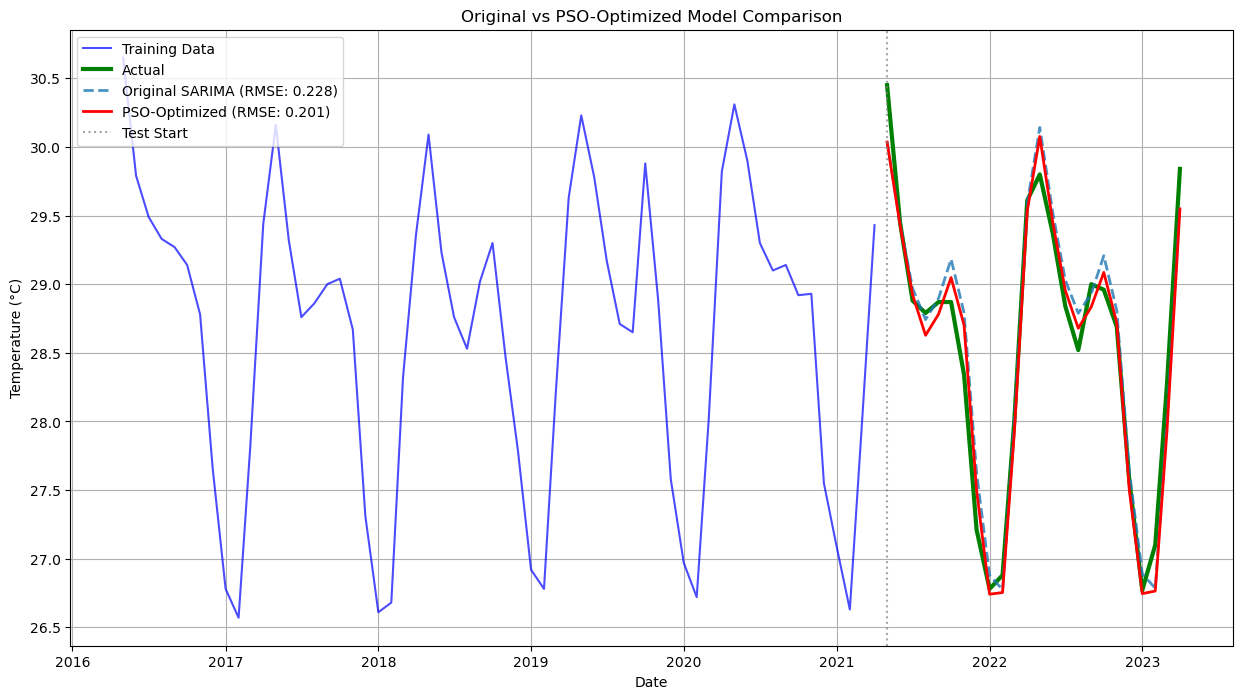

In [14]:
# =============================================================================
# OPTIMIZATION RESULTS COMPARISON
# =============================================================================

print("\n" + "="*50)
print("OPTIMIZATION RESULTS")
print("="*50)

# Calculate metrics for optimized model
optimized_metrics = evaluate_model(test_data, optimized_forecast, "PSO-Optimized")

# Compare results
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"\nComparison Results:")
print(f"Original {best_model_name} RMSE: {original_rmse:.4f}")
print(f"PSO-Optimized RMSE: {optimal_rmse:.4f}")
print(f"Improvement: {improvement:.2f}%")

# Final comparison plot
plt.figure(figsize=(15, 8))
plt.plot(train_data.index[-60:], train_data.iloc[-60:], 
         label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, 
         label='Actual', color='green', linewidth=3)

if best_model_name == 'SARIMA':
    plt.plot(test_data.index, sarima_forecast, 
             label=f'Original SARIMA (RMSE: {original_rmse:.3f})', 
             linestyle='--', alpha=0.8, linewidth=2)
elif best_model_name == 'SARIMAX':
    plt.plot(test_data.index, sarimax_forecast, 
             label=f'Original SARIMAX (RMSE: {original_rmse:.3f})', 
             linestyle='--', alpha=0.8, linewidth=2)
else:
    plt.plot(test_data.index, arima_forecast, 
             label=f'Original ARIMA (RMSE: {original_rmse:.3f})', 
             linestyle='--', alpha=0.8, linewidth=2)

plt.plot(test_data.index, optimized_forecast, 
         label=f'PSO-Optimized (RMSE: {optimal_rmse:.3f})', 
         linestyle='-', linewidth=2, color='red')

plt.axvline(x=test_data.index[0], color='gray', linestyle=':', alpha=0.7, label='Test Start')
plt.title('Original vs PSO-Optimized Model Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


FUTURE FORECASTING


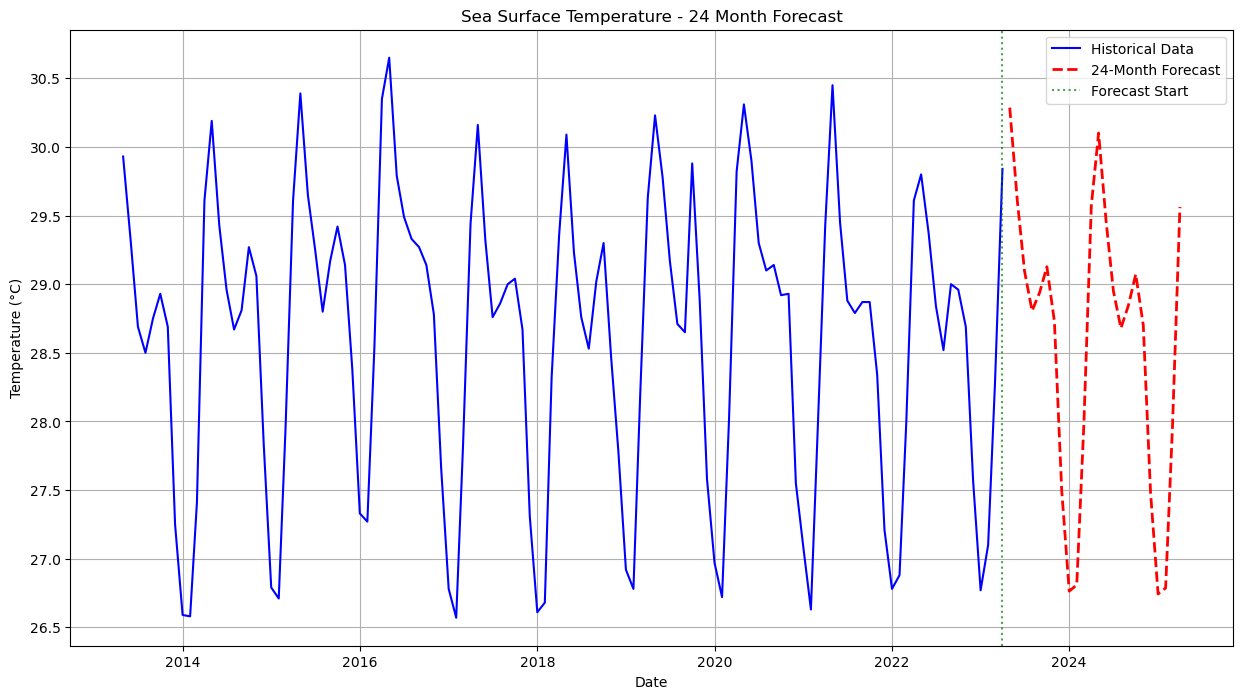

Future forecast values (next 24 months):
                 Date  Forecasted_Temperature
2023-05-01 2023-05-01               30.286202
2023-06-01 2023-06-01               29.611209
2023-07-01 2023-07-01               29.094526
2023-08-01 2023-08-01               28.805557
2023-09-01 2023-09-01               28.939080
2023-10-01 2023-10-01               29.127148
2023-11-01 2023-11-01               28.728136
2023-12-01 2023-12-01               27.498924
2024-01-01 2024-01-01               26.763635
2024-02-01 2024-02-01               26.809687
2024-03-01 2024-03-01               27.967669
2024-04-01 2024-04-01               29.572406
2024-05-01 2024-05-01               30.101495
2024-06-01 2024-06-01               29.456327
2024-07-01 2024-07-01               28.949490
2024-08-01 2024-08-01               28.679104
2024-09-01 2024-09-01               28.846945
2024-10-01 2024-10-01               29.073080
2024-11-01 2024-11-01               28.700404
2024-12-01 2024-12-01               27.

In [15]:
# =============================================================================
# FUTURE FORECASTING
# =============================================================================

print("\n" + "="*50)
print("FUTURE FORECASTING")
print("="*50)

# Retrain optimized model on full dataset
full_model = SARIMAX(temp_data['Temperature'],
                    order=tuple(optimal_params[:3]),
                    seasonal_order=(optimal_params[3], optimal_params[4], optimal_params[5], 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

if best_model_name == 'SARIMAX':
    full_exog = create_exogenous_features(temp_data['Temperature'])
    full_model = SARIMAX(temp_data['Temperature'],
                        exog=full_exog,
                        order=tuple(optimal_params[:3]),
                        seasonal_order=(optimal_params[3], optimal_params[4], optimal_params[5], 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

full_fitted = full_model.fit(disp=False)

# Forecast next 24 months
forecast_steps = 24
if best_model_name == 'SARIMAX':
    # Create future exogenous variables
    future_dates = pd.date_range(start=temp_data.index[-1] + pd.DateOffset(months=1), 
                                periods=forecast_steps, freq='MS')
    future_exog = create_exogenous_features(pd.Series(index=future_dates))
    future_forecast = full_fitted.forecast(steps=forecast_steps, exog=future_exog)
else:
    future_forecast = full_fitted.forecast(steps=forecast_steps)

# Create future dates
future_dates = pd.date_range(start=temp_data.index[-1] + pd.DateOffset(months=1), 
                            periods=forecast_steps, freq='MS')

# Plot future forecast
plt.figure(figsize=(15, 8))
plt.plot(temp_data.index[-120:], temp_data['Temperature'].iloc[-120:], 
         label='Historical Data', color='blue')
plt.plot(future_dates, future_forecast, 
         label='24-Month Forecast', color='red', linewidth=2, linestyle='--')
plt.axvline(x=temp_data.index[-1], color='green', linestyle=':', 
           alpha=0.7, label='Forecast Start')
plt.title('Sea Surface Temperature - 24 Month Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Future forecast values (next 24 months):")
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Temperature': future_forecast
})
print(forecast_df)

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)